Epoch 1/100, Train Loss: 0.0067, Validation Loss: 0.0050
Epoch 2/100, Train Loss: 0.0050, Validation Loss: 0.0047
Epoch 3/100, Train Loss: 0.0048, Validation Loss: 0.0047
Epoch 4/100, Train Loss: 0.0048, Validation Loss: 0.0047
Epoch 5/100, Train Loss: 0.0048, Validation Loss: 0.0048
Epoch 6/100, Train Loss: 0.0047, Validation Loss: 0.0047
Epoch 7/100, Train Loss: 0.0047, Validation Loss: 0.0046
Epoch 8/100, Train Loss: 0.0047, Validation Loss: 0.0046
Epoch 9/100, Train Loss: 0.0047, Validation Loss: 0.0047
Epoch 10/100, Train Loss: 0.0047, Validation Loss: 0.0046
Epoch 11/100, Train Loss: 0.0047, Validation Loss: 0.0047
Epoch 12/100, Train Loss: 0.0047, Validation Loss: 0.0046
Epoch 13/100, Train Loss: 0.0047, Validation Loss: 0.0046
Epoch 14/100, Train Loss: 0.0047, Validation Loss: 0.0047
Epoch 15/100, Train Loss: 0.0047, Validation Loss: 0.0047
Epoch 16/100, Train Loss: 0.0047, Validation Loss: 0.0046
Epoch 17/100, Train Loss: 0.0047, Validation Loss: 0.0046
Epoch 18/100, Train Los

c:\Users\Manikandan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Loss: 0.0048, MAE: 0.05, RMSE: 0.07


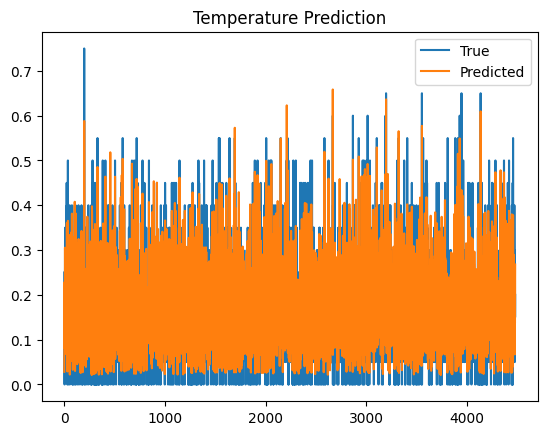

In [3]:


# Import Libraries
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load and Preprocess the Data
temperature = pd.read_csv("C:/Users/Manikandan/Desktop/class/applications of ai/assignment 5/wind_speed.csv")
humidity = pd.read_csv("C:/Users/Manikandan/Desktop/class/applications of ai/assignment 5/humidity.csv")
wind_speed = pd.read_csv("C:/Users/Manikandan/Desktop/class/applications of ai/assignment 5/wind_speed.csv")


# Convert 'datetime' column to datetime format
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
humidity['datetime'] = pd.to_datetime(humidity['datetime'])
wind_speed['datetime'] = pd.to_datetime(wind_speed['datetime'])

# Select relevant city ('Boston') and rename columns
temperature = temperature[['datetime', 'Boston']].rename(columns={'Boston': 'temperature'})
humidity = humidity[['datetime', 'Boston']].rename(columns={'Boston': 'humidity'})
wind_speed = wind_speed[['datetime', 'Boston']].rename(columns={'Boston': 'wind_speed'})

# Merge the datasets on 'datetime'
data = pd.merge(temperature, humidity, on='datetime', how='inner')
data = pd.merge(data, wind_speed, on='datetime', how='inner')

# Set 'datetime' as the index
data.set_index('datetime', inplace=True)
data.dropna(inplace=True)

# Add Lag Features for Better Context
data['temperature_lag1'] = data['temperature'].shift(1)
data['humidity_lag1'] = data['humidity'].shift(1)
data['wind_speed_lag1'] = data['wind_speed'].shift(1)
data.dropna(inplace=True)

# Normalize the features and target
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Save the scaler for use during prediction
import joblib
joblib.dump(scaler, "scaler.pkl")

# Create Sequences for Time-Series Data
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length, :-1]  # Use all features except the target
        label = data[i+sequence_length, 0]  # Target is temperature
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 24  # Using 24-hour sequences
X, y = create_sequences(scaled_data, sequence_length)

# Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define PyTorch Dataset and DataLoader
class WeatherDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = WeatherDataset(X_train, y_train)
val_dataset = WeatherDataset(X_val, y_val)
test_dataset = WeatherDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define the Enhanced LSTM Model
class EnhancedLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(EnhancedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)  # Additional fully connected layer
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = torch.relu(self.fc1(h_n[-1]))
        output = self.fc2(x)
        return output

input_dim = X_train.shape[2]
hidden_dim = 128  # Increased hidden size for better learning
output_dim = 1
num_layers = 2

model = EnhancedLSTMModel(input_dim, hidden_dim, output_dim, num_layers)

# Training Configuration
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Train the Model
epochs = 100
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    train_loss /= len(train_loader)
    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "enhanced_model.pth")

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Evaluate the Model
model.load_state_dict(torch.load("enhanced_model.pth"))
model.eval()

test_loss = 0.0
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred_batch = model(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(y_pred_batch.squeeze().numpy())
        loss = criterion(y_pred_batch.squeeze(), y_batch)
        test_loss += loss.item()

test_loss /= len(test_loader)
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"Test Loss: {test_loss:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Visualize Predictions
plt.plot(y_true, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Temperature Prediction")
plt.show()
